# RoboSINDy: Project Introduction

**Authors**: Julian Skifstad and Advaith Balaji

This notebook implements the paper "Data-driven discovery of coordinates and governing equations" by Champion et al. on the Franka Panda Arm. The goal is to compare this method with e2c. This work aims to explore and evaluate the performance of these approaches in a robotic planar pushing task.

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from numpngw import write_apng
from IPython.display import Image
from tqdm.notebook import tqdm
import time

In [12]:
from utils.panda_pushing_env import PandaImageSpacePushingEnv
from utils.visualizers import GIFVisualizer, NotebookVisualizer
from utils.utils import *
from sindy.SINDy import RoboSINDy, SindyDataset, NormalizationTransform, PushingImgSpaceController, img_space_pushing_cost_function
from utils.panda_pushing_env import TARGET_POSE_FREE, TARGET_POSE_OBSTACLES, OBSTACLE_HALFDIMS, OBSTACLE_CENTRE, BOX_SIZE

Visualize panda arm environment in gym. Executes 3 random pushes.

In [ ]:
%matplotlib inline

# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# Initialize the simulation environment
env = PandaImageSpacePushingEnv(visualizer=visualizer,
                                render_non_push_motions=True,
                                camera_heigh=800,
                                camera_width=800,
                                grayscale=True,
                                done_at_goal=False)
env.reset()
# Perform a sequence of 3 random actions:
states = []
for i in tqdm(range(3)):
    action_i = env.action_space.sample()
    state, reward, done, info = env.step(action_i)
    states.append(state)
    if done:
        break

view_states(states)

plt.close(fig)

Collect a dataset npy file that also included the state_derivatives. This will open the npy file in dataset_path and compute the state discrete time derivatives using central difference formula. It will then repackage states, actions, and state derivatives into a new .npy file which we can use as our dataset.

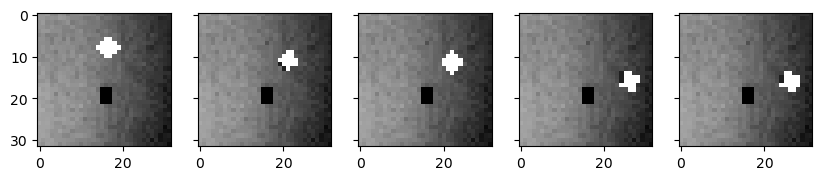

Number of samples: 900
Sample state shape: (32, 32, 1)
Sample action shape: (3,)
Sample state derivative shape: (32, 32, 1)


In [13]:
dataset_path = "datasets/collected_data_large_push.npy"
dt = 1/240.0 # time step in pybullet


data_npy = np.load(dataset_path, allow_pickle=True)

samples = []
for item in data_npy:
    
    states = item['states']
    actions = item['actions']
    state_derivatives = []
    for i in range(1, len(states)-1):
        state_derivative = (states[i+1] - states[i-1]) / dt
        state_derivatives.append(state_derivative)
    state_derivatives = np.array(state_derivatives)

    for i, state in enumerate(states[1:-1]):
        sample = {
            'state': state,
            'action': actions[i],
            'state_derivative': state_derivatives[i]
        }
        samples.append(sample)

view_states([sample['state'] for sample in samples[:5]])

# print info about samples
print(f"Number of samples: {len(samples)}")
print(f"Sample state shape: {samples[0]['state'].shape}")
print(f"Sample action shape: {samples[0]['action'].shape}")
print(f"Sample state derivative shape: {samples[0]['state_derivative'].shape}")

In [14]:
# Some training and datset parameters
val_fraction = 0.2
batch_size = 64
num_epochs = 10000

The cell below will construct the Dataset used for RoboSINDy. It reads each sample from the .npy samples we created, normalizes each state and state derivatives, and constructs a dataloader to be used for training.

In [15]:
dataset = SindyDataset(data=samples)

val_size = int(val_fraction * len(dataset))
train_size = len(dataset) - val_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

tot_train_states = []
tot_train_state_derivatives = []
for i in range(len(train_loader.dataset)):
    s = train_loader.dataset[i]['states']   
    sd = train_loader.dataset[i]['state_derivatives']  
    tot_train_states.append(s.unsqueeze(0))
    tot_train_state_derivatives.append(sd.unsqueeze(0))
tot_train_states = torch.cat(tot_train_states,dim=0)  
tot_train_state_derivatives = torch.cat(tot_train_state_derivatives, dim=0)  # (N,C,H,W)

mean_s = tot_train_states .mean(dim=(0,2,3))
std_s = tot_train_states .std( dim=(0,2,3))
mean_sd = tot_train_state_derivatives.mean(dim=(0,2,3))
std_sd = tot_train_state_derivatives.std( dim=(0,2,3))

normalization_constants = {
  'mean_state': mean_s,              
  'std_state':  std_s,               
  'mean_state_derivative': mean_sd,  
  'std_state_derivative': std_sd,    
}

norm_tr = NormalizationTransform(normalization_constants)
train_data.dataset.transform = norm_tr
val_data.dataset.transform = norm_tr

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

print(f"Loaded {len(train_loader.dataset)} training samples and {len(val_loader.dataset)} validation samples.\n")

# get one sample and check quality
sample = train_loader.dataset[0]
print(f"Sample state shape: {sample['states'].shape}")
print(f"Sample action shape: {sample['actions'].shape}")
print(f"Sample state derivative shape: {sample['state_derivatives'].shape}")
print(f"Sample state: {sample['states']}")


Loaded 720 training samples and 180 validation samples.

Sample state shape: torch.Size([1, 32, 32])
Sample action shape: torch.Size([3])
Sample state derivative shape: torch.Size([1, 32, 32])
Sample state: tensor([[[ 0.8842,  0.8842,  0.9363,  ..., -1.0428, -1.0428, -1.2511],
         [ 0.8842,  0.8842,  0.7280,  ..., -1.4073, -1.3032, -1.2511],
         [ 0.7800,  0.9363,  0.5717,  ..., -1.2511, -1.2511, -1.3032],
         ...,
         [ 1.0925,  1.1446,  1.0404,  ..., -1.7719, -1.5636, -1.5115],
         [ 1.0925,  0.8842,  0.9884,  ..., -1.7198, -1.6157, -1.6677],
         [ 0.9363,  0.7280,  1.0404,  ..., -1.4073, -1.5115, -1.9281]]])


# Part 1: SINDy Dynamics model with 2 latent dimensions

#### We first train a model that learns the latent dynamics of the planar pushing task with 2 latent variables. The hope is that the 2 latent variables will each capture the dynamics of the object in the $x$ and $y$ direction.

In [ ]:
#define the model
model = RoboSINDy(input_dim=32*32*1, batch_size=batch_size)

model.train_model(train_loader, num_epochs=num_epochs, learning_rate=0.001)

#save the model
model_path = 'trained_models/sindy_model_v3_latent2.pt'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Load model from .pt file. Skip if you just trained the model!

In [16]:
#load model from state dict

### SET THE PATH TO YOUR MODEL HERE ###
model_path = 'trained_models/sindy_model_v2_latent2.pt'
########################################

sindy_dynamics_model = RoboSINDy(input_dim=32*32*1, batch_size=batch_size, latent_dim=2)
sindy_dynamics_model.load_state_dict(torch.load(model_path))
sindy_dynamics_model.eval()
print(f"Model loaded from {model_path}")

Model loaded from trained_models/sindy_model_v2_latent2.pt


In [17]:
sindy_dynamics_model.xi_coefficients.data = mask_xi_matrix(sindy_dynamics_model.xi_coefficients.data)

print("Xi coefficients:")
print(sindy_dynamics_model.xi_coefficients.data.numpy())

Xi coefficients:
[[ 0.          0.        ]
 [-0.          1.7897408 ]
 [ 0.9017911  -0.        ]
 [ 0.12023195  0.        ]
 [-0.          0.21583366]
 [ 0.10632575  0.        ]]


Visualize the robot pushing the block using the image space dynamics inferred by SINDy.

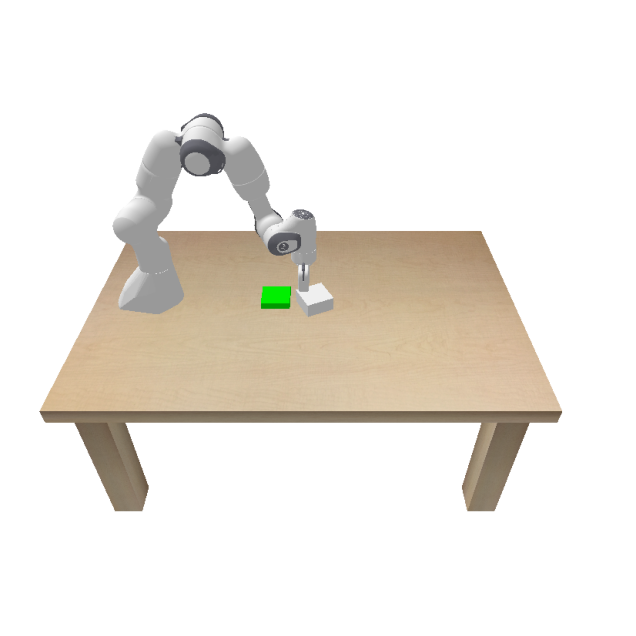

argv[0]=--opengl2
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.Size([50, 1024])
state shape:  torch.

KeyboardInterrupt: 

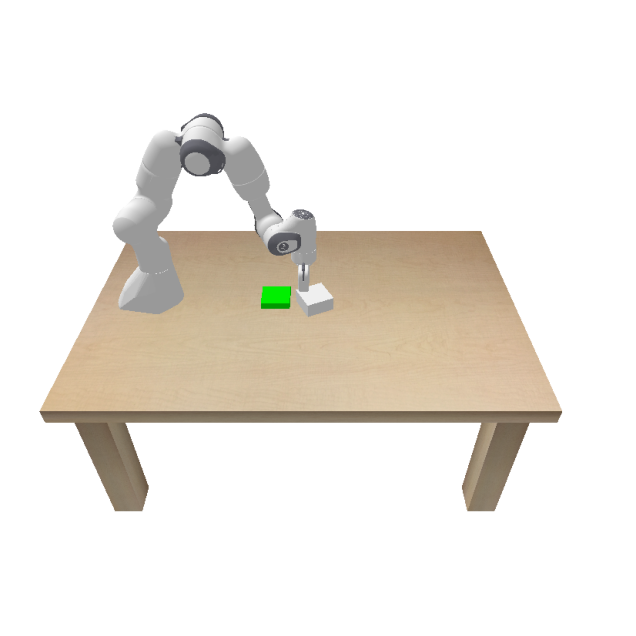

In [20]:
import pybullet as p

# Control on an obstacle free environment
%matplotlib inline

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# start_state = np.array([0.4, 0.0, 0.0])
# target_state = np.array([0.7, -0.0, 0.0])

start_state = np.array([0.4, 0.3, -np.pi/2])
target_state = np.array([0.4, -0.0, 0.0])

# start_state = np.array([0.3, 0.3, np.pi])
# target_state = np.array([0.0, 0.3, 0.0])
                
# start_state = np.array([0.6, 0.1, -np.pi/4])
# target_state = np.array([0.8, -0.0, 0.0])

############### choose number of trials to run ###################
num_trials = 3
##################################################################

for i in range(num_trials):
    env = PandaImageSpacePushingEnv(visualizer=visualizer, render_non_push_motions=False,  camera_heigh=800, camera_width=800, render_every_n_steps=5, grayscale=True, target_pose_vis=target_state, start_state=start_state)
    env.object_target_pose = env._planar_pose_to_world_pose(target_state)
    state_0 = env.reset()
    controller = PushingImgSpaceController(env, sindy_dynamics_model, img_space_pushing_cost_function, normalization_constants, num_samples=50, horizon=10)

    state = state_0

    num_steps_max = 15

    trajectory = []
    goal_reached = False
    for i in range(num_steps_max):
        action = controller.control(state)
        state, reward, done, _ = env.step(action)

        # check if we have reached the goal
        end_pose = env.get_object_pos_planar()
        trajectory.append(end_pose)
        goal_distance = np.linalg.norm(end_pose[:2]-target_state[:2]) # evaluate only position, not orientation
        goal_reached = goal_distance < BOX_SIZE/2
        if done or goal_reached:
            break

    ########### WRITRE PATH TO SAVE TRAJECTORIES ############
    trajectory_file = "trash.txt"
    write_traj_to_file(trajectory=trajectory, filename=trajectory_file)
    #########################################################

    print(f'GOAL REACHED: {goal_reached}')


plt.close(fig)

# Part 2: SINDy Dynamics model with 3 latent dimensions

#### We will now train a model that learns the latent dynamics of the planar pushing task with **3** latent variables. This model will likely be more expressive. 

In [ ]:
#define the model
model = RoboSINDy(input_dim=32*32*1, batch_size=batch_size, latent_dim=3)

model.train_model(train_loader, num_epochs=num_epochs, learning_rate=0.001)

#save the model
model_path = 'trained_models/sindy_model_v9_latent3.pt'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

In [36]:
#load model from state dict

### SET THE PATH TO YOUR MODEL HERE ###
model_path = 'trained_models/sindy_model_v4_latent3.pt'
########################################

sindy_dynamics_model = RoboSINDy(input_dim=32*32*1, batch_size=batch_size, latent_dim=3)
sindy_dynamics_model.load_state_dict(torch.load(model_path))
sindy_dynamics_model.eval()
print(f"Model loaded from {model_path}")

Model loaded from trained_models/sindy_model_v4_latent3.pt


In [37]:
sindy_dynamics_model.xi_coefficients.data = mask_xi_matrix(sindy_dynamics_model.xi_coefficients.data)

print("Xi coefficients:")
print(sindy_dynamics_model.xi_coefficients.data.numpy())

Xi coefficients:
[[-0.          0.          0.        ]
 [ 0.36756027  0.5406849   0.        ]
 [-0.         -0.         -0.        ]
 [-0.         -0.         -0.        ]
 [-0.         -0.          0.        ]
 [ 0.554955    0.5229288   0.64692813]
 [ 0.          0.         -0.        ]
 [ 0.51655674  0.62658197  0.24417885]
 [-0.         -0.         -0.        ]
 [ 0.7400743   0.9241441   0.4741933 ]
 [ 0.          0.          0.        ]
 [ 0.         -0.         -0.        ]
 [ 0.          0.          0.        ]
 [ 0.24372534  0.34643325 -0.        ]]


In [ ]:
import pybullet as p

# Control on an obstacle free environment
%matplotlib inline

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

start_state = np.array([0.4, 0.0, 0.0])
target_state = np.array([0.7, -0.0, 0.0])

# start_state = np.array([0.4, 0.3, -np.pi/2])
# target_state = np.array([0.4, -0.0, 0.0])

# start_state = np.array([0.3, 0.3, np.pi])
# target_state = np.array([0.0, 0.3, 0.0])
                
# start_state = np.array([0.6, 0.1, -np.pi/4])
# target_state = np.array([0.8, -0.0, 0.0])

############### choose number of trials to run ###################
num_trials = 3
##################################################################

for i in range(num_trials):
    env = PandaImageSpacePushingEnv(visualizer=visualizer, render_non_push_motions=False,  camera_heigh=800, camera_width=800, render_every_n_steps=5, grayscale=True, target_pose_vis=target_state, start_state=start_state)
    env.object_target_pose = env._planar_pose_to_world_pose(target_state)
    state_0 = env.reset()
    controller = PushingImgSpaceController(env, sindy_dynamics_model, img_space_pushing_cost_function, normalization_constants, num_samples=50, horizon=10)

    state = state_0

    num_steps_max = 15

    trajectory = []
    goal_reached = False
    for i in range(num_steps_max):
        action = controller.control(state)
        state, reward, done, _ = env.step(action)

        # check if we have reached the goal
        end_pose = env.get_object_pos_planar()
        trajectory.append(end_pose)
        goal_distance = np.linalg.norm(end_pose[:2]-target_state[:2]) # evaluate only position, not orientation
        goal_reached = goal_distance < BOX_SIZE/2
        if done or goal_reached:
            break

    ########### WRITRE PATH TO SAVE TRAJECTORIES ############
    trajectory_file = "trash.txt"
    write_traj_to_file(trajectory=trajectory, filename=trajectory_file)
    #########################################################

    print(f'GOAL REACHED: {goal_reached}')


plt.close(fig)

# Part 3: SINDy Dynamics model with 1 latent dimension

#### We will now train a model that learns the latent dynamics of the planar pushing task with **1** latent variable. I wonder what this will recover?

In [ ]:
# TRAIN MODEL WITH LATENT DIMENSION 1

#define the model
model = RoboSINDy(input_dim=32*32*1, batch_size=batch_size, latent_dim=1)

model.train_model(train_loader, num_epochs=num_epochs, learning_rate=0.001)

#save the model
model_path = 'trained_models/sindy_model_v12_latent1.pt'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

In [29]:
#load model from state dict

### SET THE PATH TO YOUR MODEL HERE ###
model_path = 'trained_models/sindy_model_v4_latent1.pt'
########################################

sindy_dynamics_model = RoboSINDy(input_dim=32*32*1, batch_size=batch_size, latent_dim=1)
sindy_dynamics_model.load_state_dict(torch.load(model_path))
sindy_dynamics_model.eval()
print(f"Model loaded from {model_path}")

Model loaded from trained_models/sindy_model_v4_latent1.pt


In [30]:
sindy_dynamics_model.xi_coefficients.data = mask_xi_matrix(sindy_dynamics_model.xi_coefficients.data)

print("Xi coefficients:")
print(sindy_dynamics_model.xi_coefficients.data.numpy())

Xi coefficients:
[[0.        ]
 [0.23002654]]


In [ ]:
import pybullet as p

# Control on an obstacle free environment
%matplotlib inline

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

start_state = np.array([0.4, 0.0, 0.0])
target_state = np.array([0.7, -0.0, 0.0])

# start_state = np.array([0.4, 0.3, -np.pi/2])
# target_state = np.array([0.4, -0.0, 0.0])

# start_state = np.array([0.3, 0.3, np.pi])
# target_state = np.array([0.0, 0.3, 0.0])
                
# start_state = np.array([0.6, 0.1, -np.pi/4])
# target_state = np.array([0.8, -0.0, 0.0])

############### choose number of trials to run ###################
num_trials = 3
##################################################################

for i in range(num_trials):
    env = PandaImageSpacePushingEnv(visualizer=visualizer, render_non_push_motions=False,  camera_heigh=800, camera_width=800, render_every_n_steps=5, grayscale=True, target_pose_vis=target_state, start_state=start_state)
    env.object_target_pose = env._planar_pose_to_world_pose(target_state)
    state_0 = env.reset()
    controller = PushingImgSpaceController(env, sindy_dynamics_model, img_space_pushing_cost_function, normalization_constants, num_samples=50, horizon=10)

    state = state_0

    num_steps_max = 15

    trajectory = []
    goal_reached = False
    for i in range(num_steps_max):
        action = controller.control(state)
        state, reward, done, _ = env.step(action)

        # check if we have reached the goal
        end_pose = env.get_object_pos_planar()
        trajectory.append(end_pose)
        goal_distance = np.linalg.norm(end_pose[:2]-target_state[:2]) # evaluate only position, not orientation
        goal_reached = goal_distance < BOX_SIZE/2
        if done or goal_reached:
            break

    ########### WRITRE PATH TO SAVE TRAJECTORIES ############
    trajectory_file = "trash.txt"
    write_traj_to_file(trajectory=trajectory, filename=trajectory_file)
    #########################################################

    print(f'GOAL REACHED: {goal_reached}')


plt.close(fig)

# Part 4: Large latent dimension

#### We now train a model with a large function library and large latent dimension (8)

In [16]:
# TRAIN MODEL WITH LATENT DIMENSION 8

#define the model
model = RoboSINDy(input_dim=32*32*1, batch_size=batch_size, latent_dim=8)

model.train_model(train_loader, num_epochs=num_epochs, learning_rate=0.001)

#save the model
model_path = 'trained_models/sindy_model_v1_latent8.pt'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Epoch 0/10000  Loss: 1.107967734336853
Epoch 500/10000  Loss: 0.39211177825927734
Epoch 1000/10000  Loss: 0.1925734132528305
Epoch 1500/10000  Loss: 0.1698763370513916
Epoch 2000/10000  Loss: 0.2008873075246811
Epoch 2500/10000  Loss: 0.14033202826976776
Epoch 3000/10000  Loss: 0.1437690258026123
Epoch 3500/10000  Loss: 0.15308785438537598
Epoch 4000/10000  Loss: 0.12189482152462006
Epoch 4500/10000  Loss: 0.12178993970155716
Epoch 5000/10000  Loss: 0.10102920234203339
Epoch 5500/10000  Loss: 0.11136617511510849
Epoch 6000/10000  Loss: 0.10062383860349655
Epoch 6500/10000  Loss: 0.10695282369852066
Epoch 7000/10000  Loss: 0.08834760636091232
Epoch 7500/10000  Loss: 0.1071559265255928
Epoch 8000/10000  Loss: 0.08769719302654266
Epoch 8500/10000  Loss: 0.09162263572216034
Epoch 9000/10000  Loss: 0.10097601264715195
Epoch 9500/10000  Loss: 0.08966626226902008
Final Loss: 0.10121359676122665
Model saved to trained_models/sindy_model_v1_latent8.pt


In [18]:
#load model from state dict

### SET THE PATH TO YOUR MODEL HERE ###
model_path = 'trained_models/sindy_model_v1_latent8.pt'
########################################

sindy_dynamics_model = RoboSINDy(input_dim=32*32*1, batch_size=batch_size, latent_dim=8)
sindy_dynamics_model.load_state_dict(torch.load(model_path))
sindy_dynamics_model.eval()
print(f"Model loaded from {model_path}")

Model loaded from trained_models/sindy_model_v1_latent8.pt


In [19]:
sindy_dynamics_model.xi_coefficients.data = mask_xi_matrix(sindy_dynamics_model.xi_coefficients.data)

print("Xi coefficients:")
print(sindy_dynamics_model.xi_coefficients.data.numpy())

Xi coefficients:
[[0.8023742  0.7995765  0.7989841  0.8054991  0.80625933 0.8021764
  0.79677945 0.7999181 ]
 [0.941172   0.9368318  0.93642884 0.9403151  0.94058764 0.93847793
  0.9371958  0.9375622 ]
 [0.86278826 0.8594811  0.85994893 0.8625406  0.86085117 0.860286
  0.8636732  0.8622674 ]
 [1.0236214  1.0209465  1.0236695  1.0251884  1.0301079  1.026799
  1.0179832  1.0208341 ]
 [1.2063103  1.2031513  1.2006748  1.2031108  1.2063869  1.2025962
  1.2055291  1.2012843 ]
 [1.2335827  1.231485   1.2347219  1.2323495  1.2322904  1.2341498
  1.2385523  1.2351012 ]
 [1.1867272  1.1845411  1.1852759  1.1840272  1.1877093  1.1873809
  1.1864971  1.1846756 ]
 [1.065903   1.0684508  1.0634698  1.0642374  1.0596559  1.0600319
  1.083385   1.0698792 ]
 [1.149211   1.1488628  1.1484764  1.148227   1.1523834  1.1497152
  1.1532918  1.1479274 ]
 [0.88858503 0.88957083 0.89556366 0.8817561  0.89286757 0.8899777
  0.9008843  0.8881107 ]
 [0.8546361  0.8499667  0.8487722  0.8520319  0.8539353  0.85284

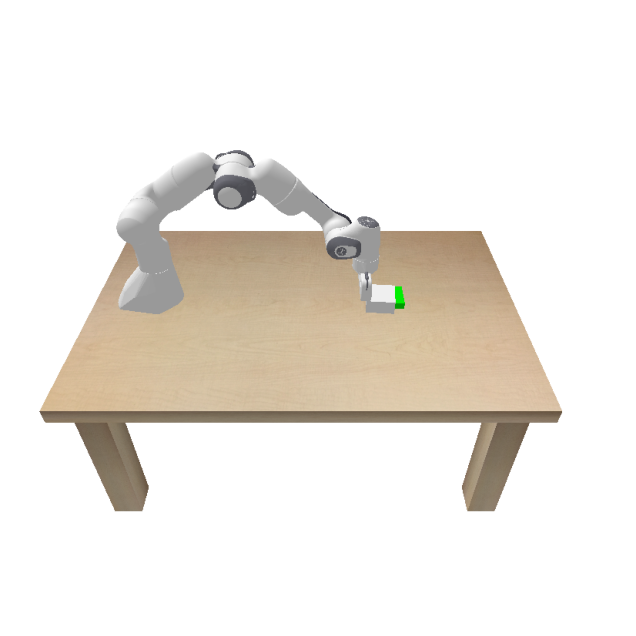

argv[0]=--opengl2
GOAL REACHED: False
argv[0]=--opengl2
GOAL REACHED: True
argv[0]=--opengl2
GOAL REACHED: True


In [25]:
import pybullet as p

# Control on an obstacle free environment
%matplotlib inline

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# start_state = np.array([0.4, 0.0, 0.0])
# target_state = np.array([0.7, -0.0, 0.0])

start_state = np.array([0.4, 0.3, -np.pi/2])
target_state = np.array([0.4, -0.0, 0.0])

# start_state = np.array([0.3, 0.3, np.pi])
# target_state = np.array([0.0, 0.3, 0.0])
                
# start_state = np.array([0.6, 0.1, -np.pi/4])
# target_state = np.array([0.8, -0.0, 0.0])

############### choose number of trials to run ###################
num_trials = 3
##################################################################

for i in range(num_trials):
    env = PandaImageSpacePushingEnv(visualizer=visualizer, render_non_push_motions=False,  camera_heigh=800, camera_width=800, render_every_n_steps=5, grayscale=True, target_pose_vis=target_state, start_state=start_state)
    env.object_target_pose = env._planar_pose_to_world_pose(target_state)
    state_0 = env.reset()
    controller = PushingImgSpaceController(env, sindy_dynamics_model, img_space_pushing_cost_function, normalization_constants, num_samples=50, horizon=10)

    state = state_0

    num_steps_max = 15

    trajectory = []
    goal_reached = False
    for i in range(num_steps_max):
        action = controller.control(state)
        state, reward, done, _ = env.step(action)

        # check if we have reached the goal
        end_pose = env.get_object_pos_planar()
        trajectory.append(end_pose)
        goal_distance = np.linalg.norm(end_pose[:2]-target_state[:2]) # evaluate only position, not orientation
        goal_reached = goal_distance < BOX_SIZE/2
        if done or goal_reached:
            break

    ########### WRITRE PATH TO SAVE TRAJECTORIES ############
    trajectory_file = "trash.txt"
    write_traj_to_file(trajectory=trajectory, filename=trajectory_file)
    #########################################################

    print(f'GOAL REACHED: {goal_reached}')


plt.close(fig)